In [52]:
import torch

from torchvision import datasets

In [53]:
data_folder = '/content/dataset'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [54]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [55]:
unique_values = tr_targets.unique()

In [56]:
print(f'tr_images & tr_targets:\n\tX -{tr_images.shape}\n\tY \-{tr_targets.shape}\n\tY-Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X -torch.Size([60000, 28, 28])
	Y \-torch.Size([60000])
	Y-Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Training a Neural Network

 1. Build a dataset that can fetch data one data point at a time.
 2. Wrap the DataLoader from the dataset.
 3. Build a model and then define the loss function and the optimizer.
 4. Define two functions to train and validate a batch of data, respectively.
 5. Define a function that will calculate the accuracy of the data.
 6. Perform weight updates based on each batch of data over increasing epochs

In [57]:
from io import IncrementalNewlineDecoder
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_folder = '/dataset'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

In [58]:
# We convert the input into float andflatten each image into 28*28 = 784
# where each numeric value corresponds to a pixel value
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()
    x = x.view(-1, 28*28)
    self.x, self.y=x, y

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    return x.to(device), y.to(device)

  def __len__(self):
    return len(self.x)

In [59]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  train_dl = DataLoader(train, batch_size=32, shuffle=True)

  return train_dl

In [60]:
from torch.optim import SGD

def get_model():
  model = nn.Sequential(
      nn.Linear(28 * 28, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10)
  ).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)

  return model, loss_fn, optimizer

In [61]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()

  pred = model(x)
  batch_loss = loss_fn(pred, y)
  batch_loss.backward()
  opt.step()
  opt.zero_grad()

  return batch_loss.item()

In [62]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()

  pred = model(x)

  max_value, arg_maxes = pred.max(-1)
  is_correct = arg_maxes == y

  return is_correct.cpu().numpy().tolist()

In [63]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

losses, accuracies = [], []

for epoch in range(5):
  print(epoch)

  epoch_losses, epoch_accuracies = [], []

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)

    epoch_losses.append(batch_loss)

  epoch_loss = np.array(epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)

    epoch_accuracies.extend(is_correct)

  epoch_accuracy = np.mean(epoch_accuracies)

  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

0
1
2
3
4


/tmp/ipython-input-2807936438.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


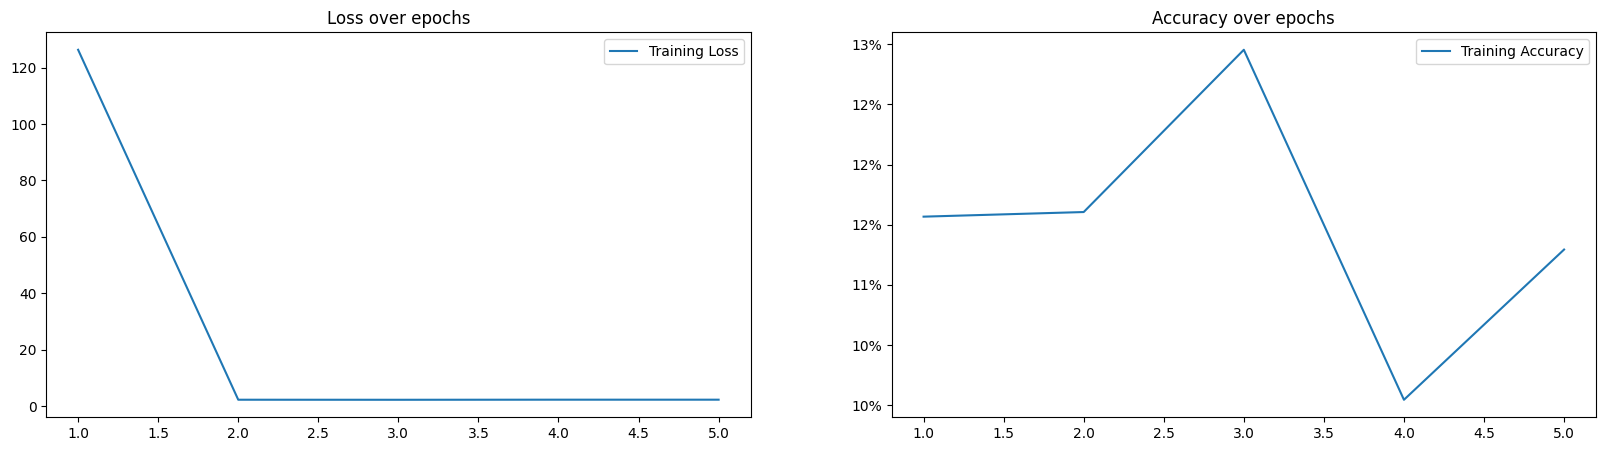

In [64]:
epochs = np.arange(5)+1

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Loss over epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy over epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                           for x in plt.gca().get_yticks()])
plt.legend()

# Scaling a Dataset

Process of ensuring that the variables are confined to a finite range

In [65]:
import numpy as np
import torch
import torch.nn as nn

from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

data_folder = 'data/'
fmnist = datasets.FashionMNIST(data_folder, download=True, \
                                  train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [66]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()/255
    x = x.view(-1, 28*28)
    self.x, self.y = x, y

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    return x.to(device), y.to(device)

  def __len__(self):
    return len(self.x)

In [67]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  return trn_dl

from torch.optim import SGD

def get_model():
  model = nn.Sequential(
      nn.Linear(28*28, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10)
  ).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
  model.train()

  pred = model(x)
  batch_loss = loss_fn(pred, y)
  batch_loss.backward()
  opt.step()
  opt.zero_grad()

  return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
  model.eval()

  pred = model(x)
  max_value, arg_maxes = pred.max(-1)
  is_correct = arg_maxes == y

  return is_correct.cpu().numpy().tolist()

In [68]:
trn_dl = get_data()
model, loss_fn, opt = get_model()
losses, accuracies = [], []

for epoch in range(5):
  print(epoch)
  epoch_losses, epoch_accuracies = [], []

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, opt, loss_fn)
    epoch_losses.append(batch_loss)

  epoch_loss = np.array(epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    epoch_accuracies.extend(is_correct)

  epoch_accuracy = np.mean(epoch_accuracies)

  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

0
1
2
3
4


/tmp/ipython-input-3315358982.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


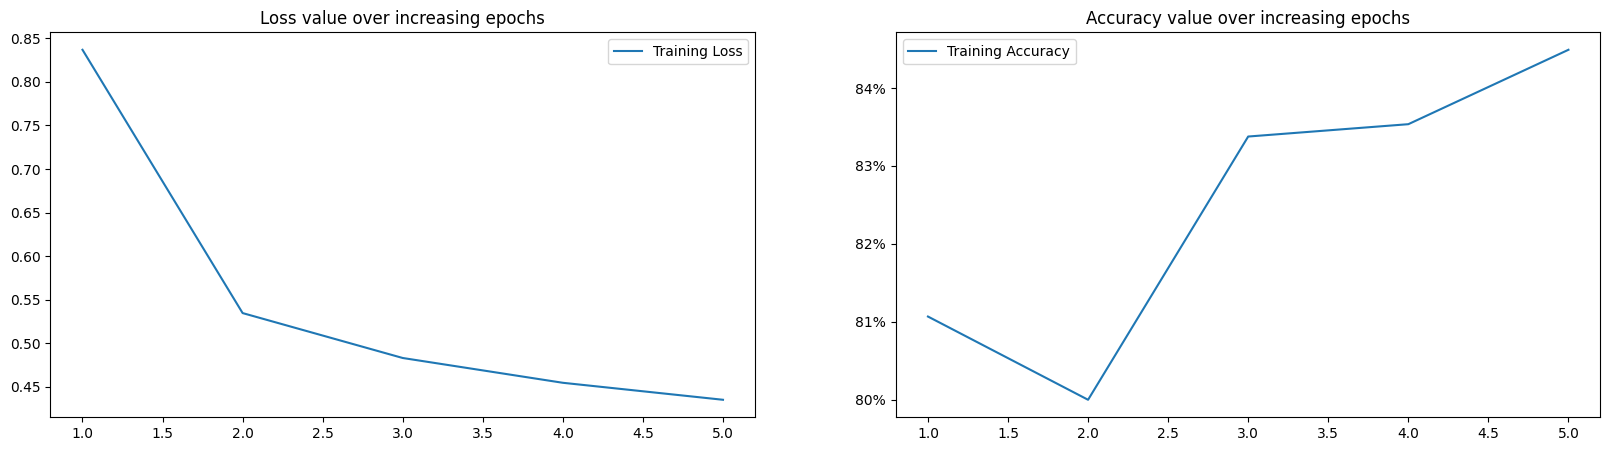

In [69]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                          for x in plt.gca().get_yticks()])
plt.legend()